# 9.9.1 图像分割和实例分割
计算机视觉领域还有2个与语义分割相似的重要问题，即图像分割（image segmentation）和实例分割（instance segmentation）。我们在这里将它们与语义分割简单区分一下。

图像分割将图像分割成若干组成区域。这类问题的方法通常利用图像中像素之间的相关性。它在训练时不需要有关图像像素的标签信息，在预测时也无法保证分割出的区域具有我们希望得到的语义。以图9.10的图像为输入，图像分割可能将狗分割成两个区域：一个覆盖以黑色为主的嘴巴和眼睛，而另一个覆盖以黄色为主的其余部分身体。
实例分割又叫同时检测并分割（simultaneous detection and segmentation）。它研究如何识别图像中各个目标实例的像素级区域。与语义分割有所不同，实例分割不仅需要区分语义，还要区分不同的目标实例。如果图像中有两只狗，实例分割需要区分像素属于这两只狗中的哪一只。

In [1]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm

import sys
sys.path.append('../code/')
import d2lzh_pytorch as d2l


In [2]:
voc_dir='../data/VOCdevkit/VOC2012'

In [3]:
def read_voc_images(root=voc_dir,is_train=True):
    txt_fname='%s/ImageSets/Segmentation/%s' % (root,'train.txt' if is_train else 'val.txt')
    with open (txt_fname,'r') as f:
        images =f.read().split()
    features,labels=[None]*len(images),[None]*len(images)
    for i,fname in tqdm(enumerate(images)):
        features[i]=Image.open('%s/JPEGImages/%s.jpg' % (root,fname)).convert('RGB')
        labels[i]=Image.open('%s/SegmentationClass/%s.png' % (root,fname)).convert('RGB')
    return features,labels

train_features,train_labels=read_voc_images(is_train=False)

1449it [00:05, 261.39it/s]


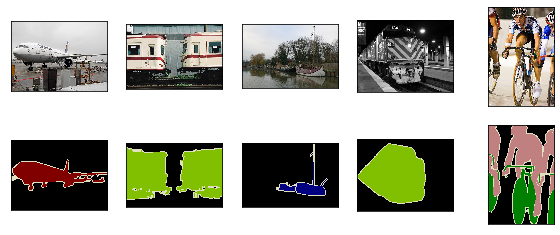

In [4]:
n=5
imgs=train_features[0:n]+train_labels[0:n]
d2l.show_images(imgs,2,n);

In [5]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
[0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
[64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
[64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
[0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
[0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
'diningtable', 'dog', 'horse', 'motorbike', 'person',
'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
colormap2label=torch.zeros(256**3,dtype=torch.uint8)
for i,colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0]*256+colormap[1])*256+colormap[2]]=i
    
def voc_label_indices(colormap,colormap2label):
    colormap=np.array(colormap.convert("RGB")).astype('int32')
    idx=((colormap[:,:,0]*256+colormap[:,:,1])*256+colormap[:,:,2])
    return colormap2label[idx]

In [7]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]
y.shape

torch.Size([281, 500])

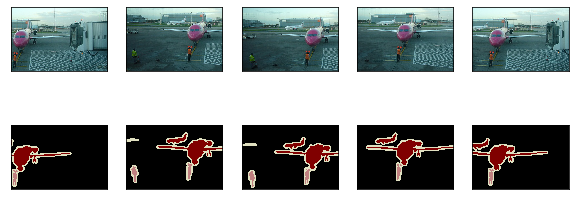

In [8]:
def voc_rand_crop(feature,label,height,width):
    i,j,h,w=torchvision.transforms.RandomCrop.get_params(feature,output_size=(height,width))
    feature=torchvision.transforms.functional.crop(feature,i,j,h,w)
    label=torchvision.transforms.functional.crop(label,i,j,h,w)
    return feature,label

imgs=[]
for _ in range(n):
    imgs+=voc_rand_crop(train_features[0],train_labels[0],200,300)
d2l.show_images(imgs[::2]+imgs[1::2],2,n);

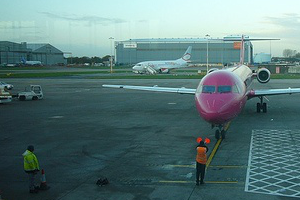

In [23]:
imgs[::2][2]

In [17]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self,is_train,crop_size,voc_dir,colormap2label):
        self.rgb_mean=np.array([0.485,0.456,0.406])
        self.rgb_std=np.array([0.229,0.224,0.225])
        self.tsf=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=self.rgb_mean,std=self.rgb_std)
        ])
        
        self.crop_size=crop_size
        features,labels=read_voc_images(root=voc_dir,is_train=is_train)
        self.features=self.filter(features)
        self.labels=self.filter(labels)
        self.colormap2label=colormap2label
        print('read ' + str(len(self.features))+' valid examples')
        
    def filter(self,imgs):
        return [img for img in imgs if(
            img.size[1]>=self.crop_size[0] and
            img.size[0]>=self.crop_size[1])]
    
    def __getitem__(self,idx):
        feature,label=voc_rand_crop(self.features[idx],self.labels[idx],*self.crop_size)
        
        return(self.tsf(feature),voc_label_indices(label,self.colormap2label))
    
    def __len__(self):
        return len(self.features)

In [18]:
crop_size=(320,480)
voc_train=VOCSegDataset(True,crop_size,voc_dir,colormap2label)
voc_test=VOCSegDataset(False,crop_size,voc_dir,colormap2label)

1464it [00:05, 280.87it/s]
32it [00:00, 317.33it/s]

read 1114 valid examples


1449it [00:05, 265.76it/s]

read 1078 valid examples


In [19]:
batch_size=64
train_iter=torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,drop_last=True)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True)

In [21]:
for X,y in train_iter:
    print(X.dtype,X.shape)
    print(y.dtype,y.shape)
    break

torch.float32 torch.Size([64, 3, 320, 480])
torch.uint8 torch.Size([64, 320, 480])
